In [53]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# ==========================================
# GLOBAL WARNING CONTROL (SAFE & CLEAN)
# ==========================================
import warnings

# 1️⃣ Ignore known, harmless FutureWarnings (seaborn / pandas)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

# 2️⃣ Ignore pandas RuntimeWarnings from NaN comparisons
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="pandas"
)

# 3️⃣ Ignore seaborn warnings (visualization only)
warnings.filterwarnings(
    "ignore",
    module="seaborn"
)

# 4️⃣ Safety: ensure numpy doesn't spam invalid comparisons
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [31]:
train=pd.read_csv("/kaggle/input/final-everything/train.csv")
test=pd.read_csv("/kaggle/input/final-everything/test.csv")

In [32]:
train.isnull().sum()

size (cm)        535
shape            773
weight (g)       684
avg_price (₹)    612
color            433
taste            459
fruit_name       400
dtype: int64

In [33]:
test.isnull().sum()

id               0
size (cm)        0
shape            0
weight (g)       0
avg_price (₹)    0
color            0
taste            0
dtype: int64

In [34]:
train = train.dropna(subset=['fruit_name']) #output label

In [35]:
test_id=test['id']
test=test.drop(columns=['id'])

In [36]:
X=train.drop(columns=['fruit_name'])
y=train['fruit_name']

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [38]:
numeric_features=X.select_dtypes(include=['int64','float64']).columns
categorical_features=X.select_dtypes(include=['object','category']).columns

In [39]:
numerical_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])
categorical_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('encode',OneHotEncoder(handle_unknown='ignore'))
])

Step 1: Histplots


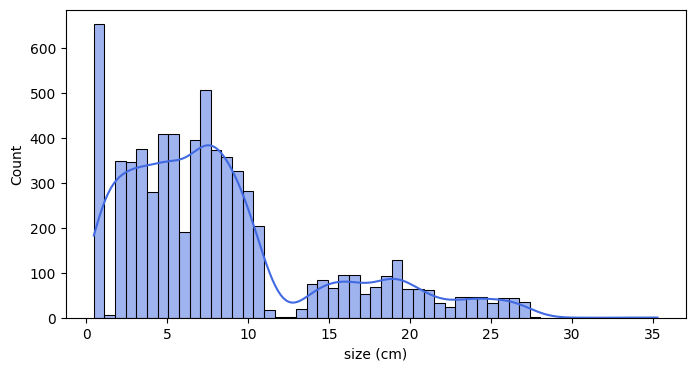

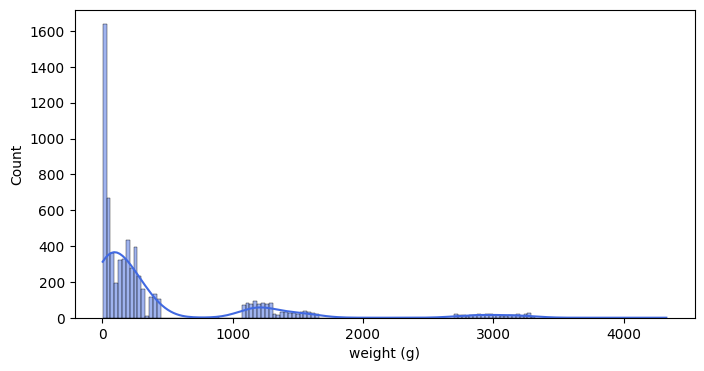

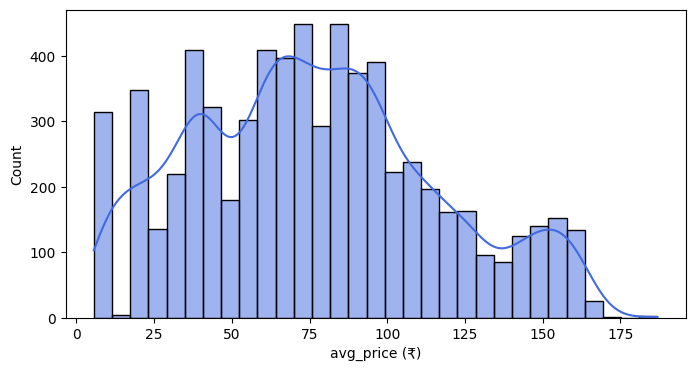

In [40]:
#VISUALISAION
# STEP 1: HISTPLOT
# ==========================================
print("Step 1: Histplots")
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(X[col].dropna(), kde=True, color='royalblue')
    plt.show()


Step 2: Target Counts
fruit_name
kiwi             392
pear             388
pineapple        384
dragon fruit     384
cherry           382
pomegranate      376
plum             375
orange           375
banana           370
blueberry        369
guava            366
lychee           366
custard apple    363
mango            358
coconut          355
watermelon       354
apple            353
grape            342
papaya           339
strawberry       325
Name: count, dtype: int64


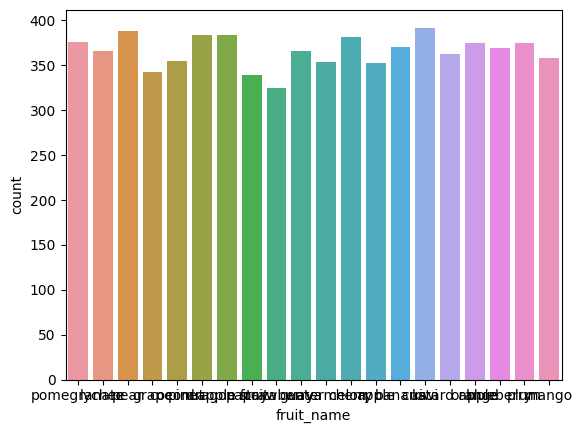

In [41]:
# ==========================================
# STEP 2: TARGET COUNTS
# ==========================================
print("\nStep 2: Target Counts")
print(y.value_counts())
sns.countplot(x=y)
plt.show()


Step 3: Boxplots (Before)


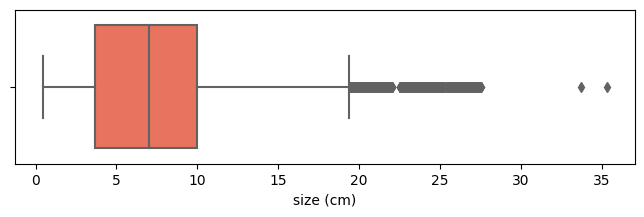

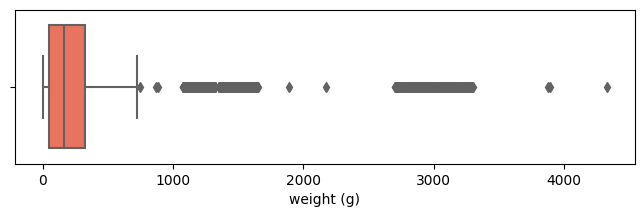

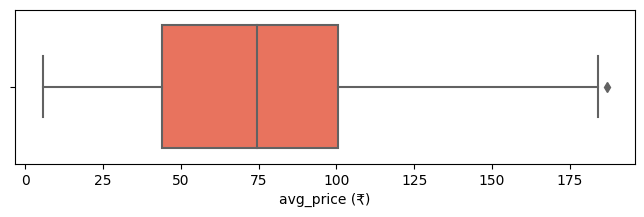

In [42]:
# ==========================================
# STEP 3: BOXPLOT (Before)
# ==========================================
print("\nStep 3: Boxplots (Before)")
for col in numeric_features:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=X[col], color='tomato')
    plt.show()

In [43]:
# ==========================================
# STEP 4: OUTLIER & INF HANDLING (ROBUST VERSION)
# ==========================================
print("\nStep 4: Handling Outliers & Converting Infinity to NaN")

# 1️⃣ Replace inf → NaN
X_train[numeric_features] = X_train[numeric_features].replace([np.inf, -np.inf], np.nan)
X_test[numeric_features]  = X_test[numeric_features].replace([np.inf, -np.inf], np.nan)

# 2️⃣ Compute IQR on TRAIN
Q1 = X_train[numeric_features].quantile(0.25)
Q3 = X_train[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# 3️⃣ Keep only valid columns (IQR > 0 and not NaN)
valid_cols = IQR[(IQR > 0) & (~IQR.isna())].index

# 4️⃣ Clip only valid columns
lower = Q1[valid_cols] - 1.5 * IQR[valid_cols]
upper = Q3[valid_cols] + 1.5 * IQR[valid_cols]

X_train[valid_cols] = X_train[valid_cols].clip(lower, upper, axis=1)
X_test[valid_cols]  = X_test[valid_cols].clip(lower, upper, axis=1)



Step 4: Handling Outliers & Converting Infinity to NaN


In [44]:
# ==========================================
# STEP 5: RE-CHECK TARGET COUNTS
# ==========================================
print(f"Total Unique Classes: {y.nunique()}")
print("-" * 30)
print(y.value_counts())

Total Unique Classes: 20
------------------------------
fruit_name
kiwi             392
pear             388
pineapple        384
dragon fruit     384
cherry           382
pomegranate      376
plum             375
orange           375
banana           370
blueberry        369
guava            366
lychee           366
custard apple    363
mango            358
coconut          355
watermelon       354
apple            353
grape            342
papaya           339
strawberry       325
Name: count, dtype: int64



Step 6: Final Visual Checks


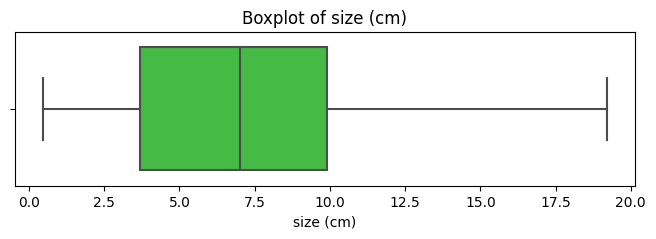

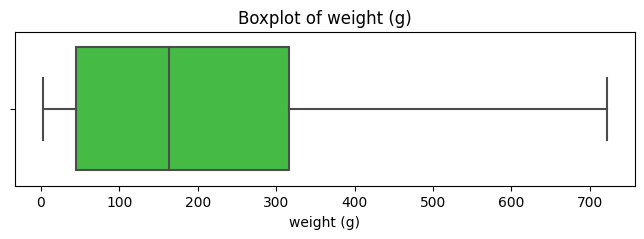

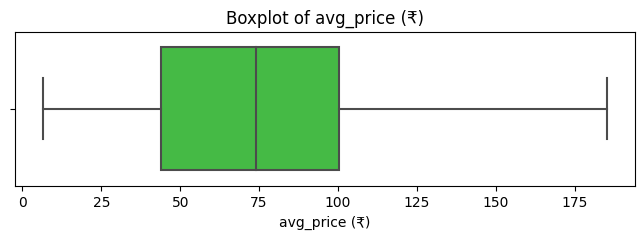

In [45]:
# ==========================================
# STEP 6: RE-CHECK BOXPLOTS (AFTER CLEANING)
# ==========================================
print("\nStep 6: Final Visual Checks")

for col in numeric_features:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=X_train[col], color='limegreen')
    plt.title(f"Boxplot of {col}")
    plt.show()



Step 7: Generating Normal Pairplot


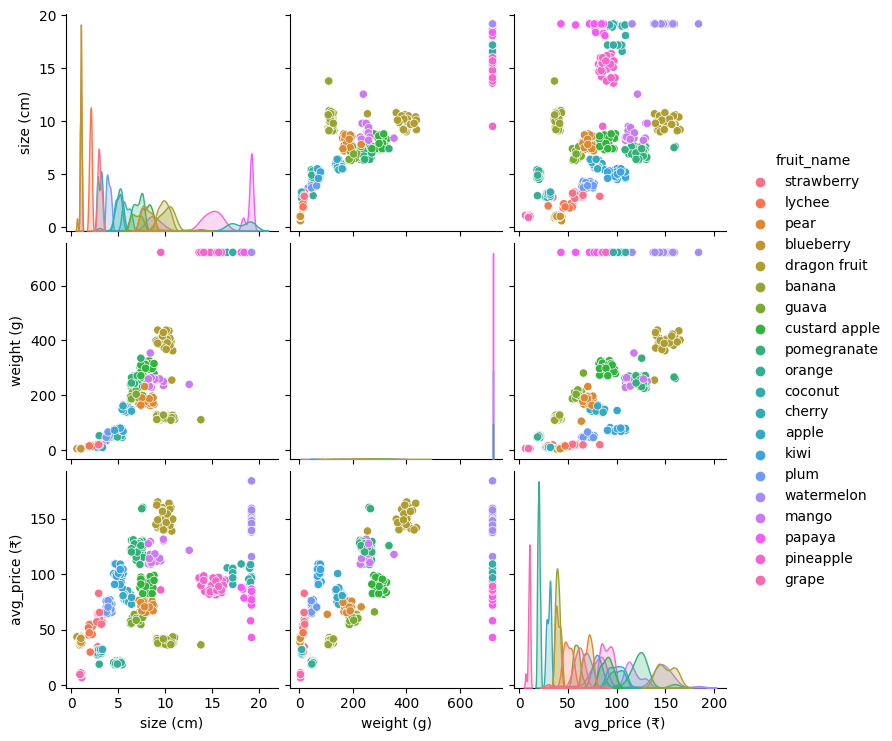

In [46]:
# ==========================================
# STEP 7: NORMAL PAIRPLOT
# ==========================================
print("\nStep 7: Generating Normal Pairplot")

plot_df = pd.concat([X_train, y_train], axis=1).sample(
    min(500, len(X_train)),
    random_state=42
)

sns.pairplot(plot_df, hue='fruit_name')
plt.show()



Step 8: Corrected Heatmap


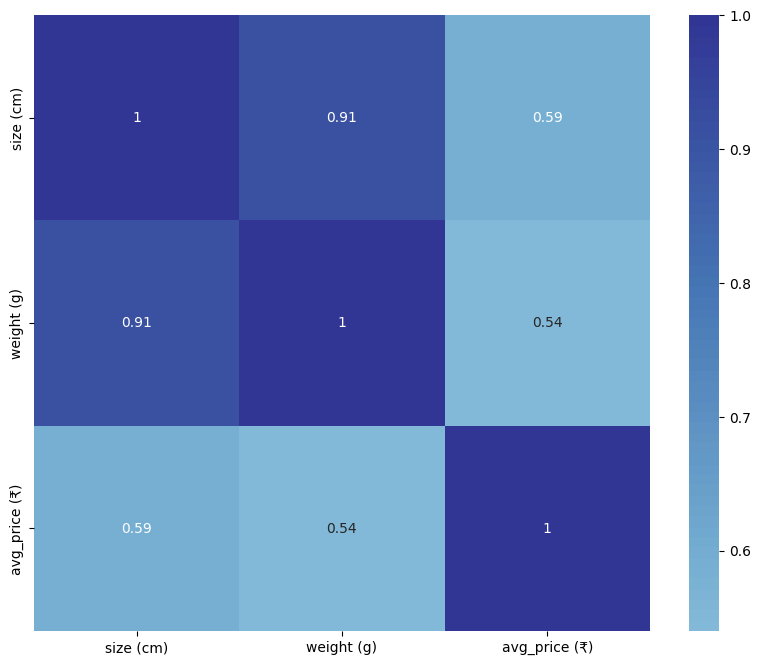

In [47]:
# ==========================================
# STEP 8: HEATMAP (Fixed)
# ==========================================
print("\nStep 8: Corrected Heatmap")
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(numeric_only=True), annot=True, cmap='RdYlBu', center=0, square=True)
plt.show()

In [48]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(
#     C=1.0,
#     penalty='l2',
#     solver='lbfgs',
#     max_iter=1000,
#     n_jobs=-1
# )

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(
#     n_estimators=400,
#     max_depth=None,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     max_features='sqrt',
#     random_state=42,
#     n_jobs=-1
# )

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     random_state=42
# )

# from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier(
#     n_estimators=500,
#     max_depth=None,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     max_features='sqrt',
#     random_state=42,
#     n_jobs=-1
# )

# from xgboost import XGBClassifier
# model = XGBClassifier(
#     n_estimators=600,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     reg_lambda=1,
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     tree_method='hist',
#     random_state=42,
#     n_jobs=-1
# )

# from lightgbm import LGBMClassifier
# model = LGBMClassifier(
#     n_estimators=600,
#     learning_rate=0.05,
#     max_depth=-1,
#     num_leaves=63,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     random_state=42,
#     n_jobs=-1
# )

# from catboost import CatBoostClassifier
# model = CatBoostClassifier(
#     iterations=600,
#     learning_rate=0.05,
#     depth=6,
#     loss_function='MultiClass',
#     random_seed=42,
#     verbose=False
# )


In [49]:
preprocessing=ColumnTransformer(transformers=[
    ('num',numerical_pipeline,numeric_features),
    ('cat',categorical_pipeline,categorical_features)
])

In [50]:
pipeline=Pipeline(steps=[
    ('preprocessor',preprocessing),
    ('model',model)
])

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # fit on train
y_test_enc = le.transform(y_test)        # transform test

In [52]:
pipeline.fit(X_train,y_train_enc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['size (cm)', 'weight (g)', 'avg_price (₹)'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['shape', 'color', 'taste'], dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=4,
                                            min_samples_leaf=2,
                                            min_samples_split=5,
                                            n_estimators=300, random_state=42,
                                            subsample=0.9))])

In [54]:
# Predict class labels
y_pred = pipeline.predict(X_test)
# Predict class probabilities (needed for log-loss, AUC, calibration)
y_pred_proba = pipeline.predict_proba(X_test)

In [55]:
# Accuracy
acc = accuracy_score(y_test_enc, y_pred)

# Log Loss
ll = log_loss(y_test_enc, y_pred_proba)

# Precision, Recall, F1 (weighted = handles class imbalance)
prec = precision_score(y_test_enc, y_pred, average='weighted')
rec  = recall_score(y_test_enc, y_pred, average='weighted')
f1   = f1_score(y_test_enc, y_pred, average='weighted')

print("Accuracy :", acc)
print("Log Loss :", ll)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


Accuracy : 0.9890710382513661
Log Loss : 0.09117098757897593
Precision: 0.9894201458237782
Recall   : 0.9890710382513661
F1 Score : 0.9891067916165971


In [57]:
final_preds=pipeline.predict(test)
final_probs=pipeline.predict_proba(test)

In [58]:
# ==========================================
# STEP 10: FINAL DATA PREPARATION
# (NO ROW DROPPED, NO NaNs INTRODUCED)
# ==========================================
print("\nStep 10: Preparing Final Submission DataFrames...")
# Decode predicted labels
decoded_labels = le.inverse_transform(final_preds)
# Highest confidence per row
highest_probs = np.max(final_probs, axis=1)
class_names = le.classes_



Step 10: Preparing Final Submission DataFrames...


In [59]:
# ==========================================
# SUBMISSION 1: ID + PREDICTED CLASS
# ==========================================
submission1_df = pd.DataFrame({
    'id': test_id,
    'fruit_name': decoded_labels
})

In [60]:
# ==========================================
# SUBMISSION 2: ID + ALL CLASS PROBABILITIES log loss jaisa
# ==========================================
prob_cols = {
    f"Status_{cls}": final_probs[:, i]
    for i, cls in enumerate(class_names)
}

submission2_df = pd.DataFrame(prob_cols)
submission2_df.insert(0, 'id', test_id)


In [61]:
# ==========================================
# SUBMISSION 3: ID + CLASS + CONFIDENCE random sa kuch to hai
# ==========================================
submission3_df = pd.DataFrame({
    'id': test_id,
    'Predicted_Class': decoded_labels,
    'Confidence_Score': highest_probs
})


In [62]:
# ==========================================
# STEP 11: EXPORT FILES 1- for prediction
# 2- log loss styled
# 3- just all the probablity in one line
# ==========================================

submission1_df.to_csv("submission1.csv", index=False)
submission2_df.to_csv("submission2.csv", index=False)
submission3_df.to_csv("submission3.csv", index=False)
print("All submissions are generated")


All submissions are generated
